# Reconocimiento de dígitos con KNN

Veamos como interactuar con las clases implementadas en el módulo de C++ haciendo una experimentación muy simplificada, y a modo de ejemplo, del método KNN para reconocer digitos

## Compilando el módulo desde C++

Definir los path al ejecutable de python 3.6 y sus librerías,
de acuerdo al virtual env que estén corriendo.

In [1]:
!cd .. && mkdir build
!cd ../build/ && rm -rf *
!cd ../build && cmake \
  -DPYTHON_EXECUTABLE="$(which python)" \
  -DCMAKE_BUILD_TYPE=Release ..
!cd ../build && make install

mkdir: cannot create directory ‘build’: File exists
-- The C compiler identification is GNU 9.3.0
-- The CXX compiler identification is GNU 9.3.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
Release mode
-- Found PythonInterp: /home/tincho/Development/tp2 gitlab/tp2/bin/python (found version "3.8.10") 
-- Found PythonLibs: /usr/lib/x86_64-linux-gnu/libpython3.8.so
-- pybind11 v2.2.4
-- Performing Test HAS_FLTO
-- Performing Test HAS_FLTO - Success
-- LTO enabled
CMAKE_INSTALL_PREFIX=/home/tincho/Development/tp2 gitlab/mn-tp2
-- Configuring done
-- Generating done
-- Build files have been written to: /home/tincho/Development/tp2 

In [2]:
# Verifico la correcta instalación. Si no falla el import está OK
!pwd
!python --version
import metnum

/home/tincho/Development/tp2 gitlab/mn-tp2/notebooks
Python 3.8.10


## Explorando los datos

In [3]:
%load_ext autoreload
%autoreload 2
import pandas as pd

df_train = pd.read_csv("../data/train.csv")
# df_trainBis = pd.read_csv("../data/train.csv")

Es un csv, con columnas por cada pixel

In [4]:
df_train[:10]

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Reducir el dataset

Ya que el dataset es grande, me quedo con una porción de éste

**<font color=red>ESTO ES SOLO PARA HACER PRUEBAS. CUANDO REPORTEN LOS RESULTADOS, USAR DATASET COMPLETO</font>**

In [5]:
df_train = df_train[:5000]

En el primer caracter está el dígito a reconocer. Llamamos a esto `y_train`

In [6]:
# Uso values para mandar todo a arrays de numpy
X = df_train[df_train.columns[1:]].values
y = df_train["label"].values.reshape(-1, 1)

X.shape, y.shape

((5000, 784), (5000, 1))

Convierto el resto a matrices de 28 x 28

A ver cómo se ven...

Supuestamente es un 7


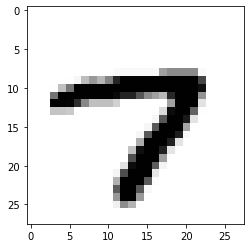

In [7]:
import matplotlib.pyplot as plt

num = 1917

print(f"Supuestamente es un {int(y[num])}")

img = X[num].reshape(28, 28)
plt.imshow(img, cmap="Greys")


### Balance de clases

¿Tenemos la misma cantidad de cada número?

In [8]:
df_train["label"].value_counts(normalize=True)

1    0.1116
2    0.1090
6    0.1032
7    0.1012
0    0.0988
3    0.0960
9    0.0956
4    0.0954
8    0.0954
5    0.0938
Name: label, dtype: float64

No: tenemos más 1 que 5, pero tampoco está tan desbalanceado

### Conjunto de development

In [9]:
limit = int(0.8 * X.shape[0]) 

X_train, y_train = X[:limit], y[:limit]
X_val, y_val = X[limit:], y[limit:]

assert len(X_train) == len(y_train)
assert len(X_val) == len(y_val)

print(f"Ahora tengo {len(X_train)} instancias de entrenamiento y {len(X_val)} de validación")


Ahora tengo 4000 instancias de entrenamiento y 1000 de validación


In [10]:
from sklearn.neighbors import KNeighborsClassifier

# Acá pueden cambiar el clasificador nuestro por el de sklearn!

clf = metnum.KNNClassifier(100)
#clf = KNeighborsClassifier(100)

clf.fit(X_train, y_train)


In [11]:
%%time
from sklearn.metrics import accuracy_score
y_pred = clf.predict(X_val)

acc = accuracy_score(y_val, y_pred)
print("Accuracy: {}".format(acc))


Accuracy: 0.832
CPU times: user 3.58 s, sys: 0 ns, total: 3.58 s
Wall time: 3.57 s


# Empiezo con la investigacion 

## Implementacion de 'k'

#### Vamos a experimentar la variacion de datos de k y alfa utilizando como metodo el KFold Cross Validation. Lo que hace es dividir nuestra muestra de datos en K subconjuntos, y bajo una metrica que elijamos, aplicarle el kNN con o sin PCA segun corresponda, para luego chequear sus resultados

#### Agarro una muestra pequena del train ya provisto por la catedra

In [12]:
df_train_small = df_train.sample(500) # Empiezo usando 500 datos primero
df_train_small.shape

X_train = df_train_small[df_train_small.columns[1:]].values
y_train = df_train_small["label"].values

print(X_train.shape)
print(y_train.shape)

(500, 784)
(500,)


#### Comienzo con una funcion de KFold que me estime la performance de los metodos codeados en C++

In [51]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score
from time import time
import numpy as np

def kNN_KFold(k, X, y):
    kfold = KFold(10)
    # kfold.get_n_splits(X)
    accuracyArr = []
    F1Arr = []
    
    for train_index, test_index in kfold.split(X):
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        kNN = metnum.KNNClassifier(k)
        
        kNN.fit(X_train, y_train)

        y_pred = kNN.predict(X_test)
        
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average="macro")
        
        accuracyArr.append(acc)
        F1Arr.append(f1)
        
    accuracyArr = np.asarray(accuracyArr)
    F1Arr = np.asarray(F1Arr)
    
    mediaAccuracy = np.mean(accuracyArr)
    mediaF1 = np.mean(F1Arr)
    
    return mediaAccuracy, mediaF1

## Variacion de 'k'

### kNN sin PCA

#### 'k' = 50

In [38]:
#%%time #Tarda como 40 segundos
def estudio_k(k, X, y):
    accuracyList = []
    F1List = []
    for i in range(1, k):
        mediaAccuracy, mediaF1 = kNN_KFold(int(i), X, y)
        accuracyList.append(mediaAccuracy)
        F1List.append(mediaF1)

    accuracyList = np.asarray(accuracyList)
    F1List = np.asarray(F1List)
    
    return accuracyList, F1List

In [52]:
%%time
accuracy10 , FOne10 = estudio_k(10, X_train, y_train)

CPU times: user 1.86 s, sys: 0 ns, total: 1.86 s
Wall time: 1.86 s


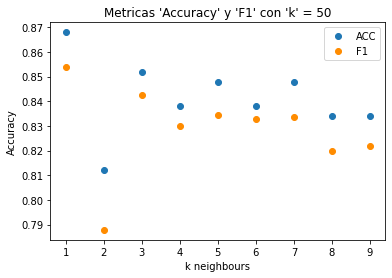

In [197]:
# pyplot.plot(range(1, 50), accuracy50, color='r')
pyplot.errorbar(range(1, 10), accuracy10, fmt='o', label='ACC')
pyplot.errorbar(range(1, 10), FOne10, fmt='o',color='darkorange', label='F1')
pyplot.legend(loc='upper right')
pyplot.xlabel("k neighbours")
pyplot.ylabel("Accuracy")
pyplot.title("Metricas 'Accuracy' y 'F1' con 'k' = 50")

# show the plot
pyplot.show()

In [39]:
%%time
accuracy50 , FOne50 = estudio_k(50, X_train, y_train)

CPU times: user 9.77 s, sys: 2.5 ms, total: 9.77 s
Wall time: 9.77 s


In [40]:
print (len(accuracy50))
print (len(FOne50))

49
49


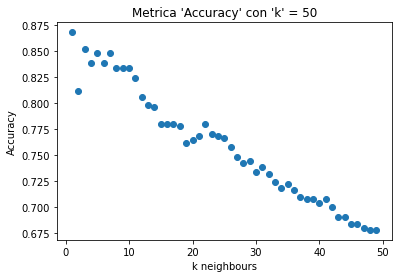

CPU times: user 187 ms, sys: 52.5 ms, total: 239 ms
Wall time: 88.4 ms


In [41]:
%%time
from matplotlib import pyplot

# pyplot.plot(range(1, 50), accuracy50, color='r')
pyplot.errorbar(range(1, 50), accuracy50, fmt='o')

pyplot.xlabel("k neighbours")
pyplot.ylabel("Accuracy")
pyplot.title("Metrica 'Accuracy' con 'k' = 50")

# show the plot
pyplot.show()

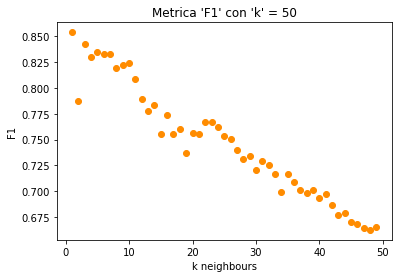

CPU times: user 187 ms, sys: 35.9 ms, total: 223 ms
Wall time: 83.9 ms


In [42]:
%%time
pyplot.errorbar(range(1, 50), FOne50, fmt='o',color='darkorange')

pyplot.xlabel("k neighbours")
pyplot.ylabel("F1")
pyplot.title("Metrica 'F1' con 'k' = 50")

# show the plot
pyplot.show()

#### 'k' = 100

In [43]:
accuracy100 , FOne100= estudio_k(100, X_train, y_train)

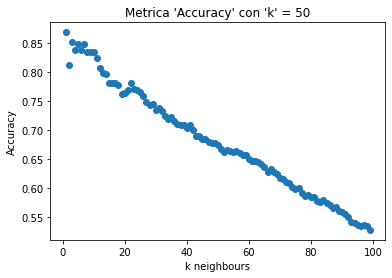

CPU times: user 186 ms, sys: 36.4 ms, total: 223 ms
Wall time: 82.9 ms


In [44]:
%%time
# como hago los puntos mas chicos?
pyplot.errorbar(range(1, 100), accuracy100, fmt='o')

pyplot.xlabel("k neighbours")
pyplot.ylabel("Accuracy")
pyplot.title("Metrica 'Accuracy' con 'k' = 50")

# show the plot
pyplot.show()

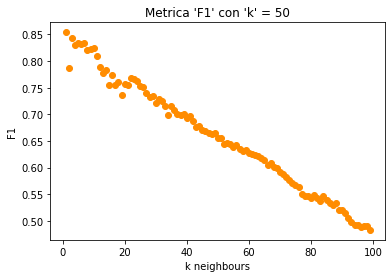

In [109]:
pyplot.errorbar(range(1, 100), FOne100, fmt='o', color='darkorange')

pyplot.xlabel("k neighbours")
pyplot.ylabel("F1")
pyplot.title("Metrica 'F1' con 'k' = 50")

# show the plot
pyplot.show()

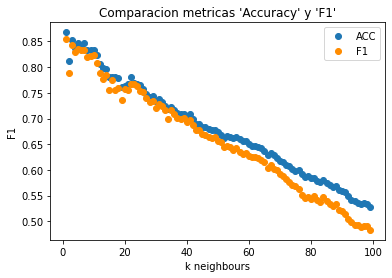

CPU times: user 186 ms, sys: 68.1 ms, total: 254 ms
Wall time: 95.4 ms


In [119]:
%%time
pyplot.errorbar(range(1, 100), accuracy100, fmt='o', label='ACC')
pyplot.errorbar(range(1, 100), FOne100, fmt='o', color='darkorange', label='F1')
pyplot.legend(loc='upper right')
pyplot.xlabel("k neighbours")
pyplot.ylabel("F1")
pyplot.title("Comparacion metricas 'Accuracy' y 'F1'")

# show the plot
pyplot.show()

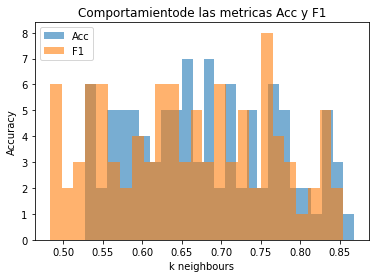

In [115]:
plt.hist(accuracy100, 25, alpha = 0.6, label='Acc')
plt.hist(FOne100, 25, alpha = 0.6, label='F1')
plt.legend(loc='upper left')
plt.title('Comportamientode las metricas Acc y F1')
plt.ylabel('Accuracy')
plt.xlabel('k neighbours')


plt.show()

## Variacion de tamano de la muestra

#### Vamos a buscar como varia la accuracy dependiendo del tamano de la muestra que tenemos. Eligiremos dos 'k' distintos, uno con una gran accuracy de base, como 'k = 4'. Y otro de menor efectividad, como por ejemplo, 'k = 100'. Tambien veremos como varia con PCA incluido y sin PCA.

### Sin PCA

In [40]:
# No se por que el kernel se muere cuando hago esta funcion
def muestra(cant):
    df_train_custom = df_trainBis.sample(cant)
    X_custom = df_train_custom[df_train_custom.columns[1:]].values
    y_custom = df_train_custom["label"].values
    
    return df_train_custom, X_custom, y_custom

#### K = 25 

In [ ]:
# No funciona muestra() D:
# df_train_25, X_train25, y_train25 = muestra(25)

df_train_25 = df_trainBis.sample(25)
X_25 = df_train_25[df_train_25.columns[1:]].values
y_25 = df_train_25["label"].values

accuracyI_4 , FOneI_4 = estudio_k(4, X_25, y_25)
accuracyI_100 , FOneI_100 = estudio_k(100, X_25, y_25)


#### K = 100

In [ ]:
# No funciona muestra() D:
# df_train_100, X_train100, y_train100 = muestra(100)

df_train_100 = df_trainBis.sample(100)
X_100 = df_trainBis[df_trainBis.columns[1:]].values
y_100 = df_trainBis["label"].values

accuracyII_4 , FOneII_4 = estudio_k(4, X_train100, y_train100)
accuracyII_100 , FOneI_100 = estudio_k(100, X_train100, y_train100)

#### K = 1000

In [68]:
# No funciona muestra() D:
# df_train_1000, X_train1000, y_train1000 = muestra(1000)
accuracyIII , FOneIII= estudio_k(50, X_train1000, y_train1000)

#### K = 1500

In [69]:
# No funciona muestra() D:
# df_train_1500, X_train1500, y_train1500 = muestra(1500)
accuracyIV , FOneIV= estudio_k(50, X_train1500, y_train1500)

#### Grafico todos los tipos de muestra para ver en que se diferencia su performance 

In [ ]:
#plt.plot([1,5,10,50,100,200],[0.508, 0.575, 0.590, 0.645, 0.646, 0.643], label='k=100')  #La primera lista son los alfas y la segunda los accuracy
#plt.plot([1,5,10,50,100,200],[0.507, 0.569, 0.590, 0.642, 0.648, 0.634], label='k=500')  #La primera lista son los alfas y la segunda los accuracy
#plt.plot([1,5,10,50,100,200],[0.510, 0.563, 0.578, 0.646, 0.661, 0.662], label='k=1500') #La primera lista son los alfas y la segunda los accuracy
#plt.plot([1,5,10,50,100,200],[0.509, 0.557, 0.569, 0.626, 0.649, 0.658], label='k=2000') #La primera lista son los alfas y la segunda los accuracy
#plt.axis([1, 200, 0.5,0.7])
plt.plot(range(1, 50), accuracyI, label='muestra=25')
plt.plot(range(1, 50), accuracyII, label='muestra=100')
plt.plot(range(1, 50), accuracyIII, label='muestra=1000')
plt.plot(range(1, 50), accuracyIV, label='muestra=1500')
plt.xlabel("Vecinos")
plt.ylabel("Accuracy")
plt.title("Performance metrica accuracy dependiendo tamano de la muestra")
plt.show()

### Con PCA

## Variacion de '\\( \alpha \\)'

#### Estudio como cambia la efectividad del metodo kNN (con k = 1 y k = 100) dependiendo el alfa

In [69]:
def estudio_alfa(a, k, X, y):
    accuracyList = []
    F1List = []
    for i in range(1, a):
        # Realizo redimension
        PCA = metnum.PCA(int(i))
        PCA.fit(X)
        X_PCA_train = PCA.transform(X)
        
        # Aplico kNN como siempre
        mediaAccuracy, mediaF1 = kNN_KFold(k, X_PCA_train, y)
        accuracyList.append(mediaAccuracy)
        F1List.append(mediaF1)

    accuracyList = np.asarray(accuracyList)
    F1List = np.asarray(F1List)
    
    return accuracyList, F1List

### PCA con k = 1

#### Comienzo con un alfa chico como '5'

In [84]:
%%time
accuracyAlpha5 , FOneAlpha5 = estudio_alfa(5, 1, X_train, y_train)

CPU times: user 371 ms, sys: 0 ns, total: 371 ms
Wall time: 373 ms


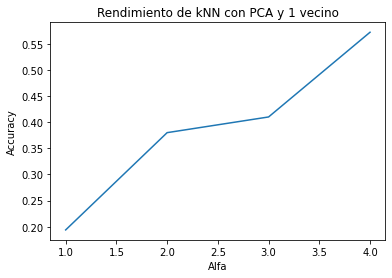

In [86]:
plt.title("Rendimiento de kNN con PCA y 1 vecino")
plt.plot(range(1, 5), accuracyAlpha5)
plt.xlabel("Alfa")
plt.ylabel("Accuracy")
plt.show()

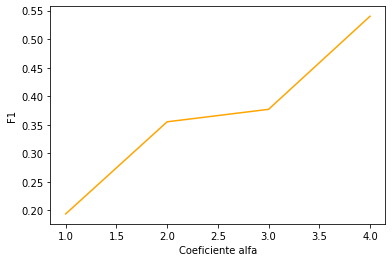

In [87]:
plt.plot(range(1, 5), FOneAlpha5, color="orange")
plt.xlabel("Alfa")
plt.ylabel("F1")
plt.show()

#### Ahora utilizo un alfa de 50

In [89]:
%%time
accuracyAlpha50 , FOneAlpha50 = estudio_alfa(50, 1, X_train, y_train)

CPU times: user 51.6 s, sys: 83.7 ms, total: 51.7 s
Wall time: 51.9 s


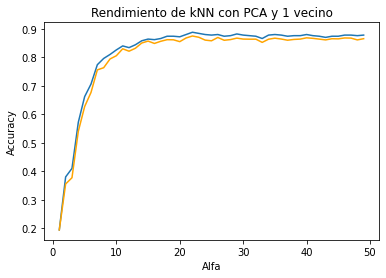

In [96]:
plt.title("Rendimiento de kNN con PCA y 1 vecino")
plt.plot(range(1, 50), accuracyAlpha50)
plt.plot(range(1, 50), FOneAlpha50, color="orange")
plt.xlabel("Alfa")
plt.ylabel("Accuracy")
plt.show()

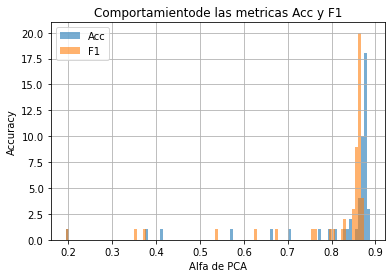

In [106]:
plt.hist(accuracyAlpha50, 100, alpha = 0.6, label='Acc')
plt.hist(FOneAlpha50, 100, alpha = 0.6, label='F1')
plt.legend(loc='upper left')
plt.title('Comportamientode las metricas Acc y F1')
plt.ylabel('Accuracy')
plt.xlabel('Alfa de PCA')
plt.grid()

plt.show()

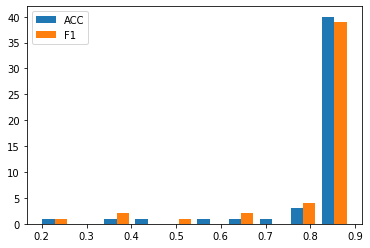

In [120]:
plt.hist([accuracyAlpha50, FOneAlpha50], label=['ACC', 'F1'])
plt.legend(loc='upper left')
plt.show()

## Variacion de 'K' del KFold

In [146]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score
from time import time
import numpy as np

# con 25 vecinos
def KFoldVariado(K, X, y):
    # No confundir K de K-fold con k de kNN!!
    kfold = KFold(K)
    kfold.get_n_splits(X)
    accuracyArr = []
    F1Arr = []
    minAccuracy = []
    maxAccuracy = []
    minF1 = []
    maxF1 = []
    
    for train_index, test_index in kfold.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        kNN = metnum.KNNClassifier(25)
        
        kNN.fit(X_train, y_train)

        y_pred = kNN.predict(X_test)
        
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average="macro")
        
        accuracyArr.append(acc)
        F1Arr.append(f1)
        
    accuracyArr = np.asarray(accuracyArr)
    F1Arr = np.asarray(F1Arr)
    
    mediaAccuracy = np.mean(accuracyArr)
    minAccuracy = np.min(accuracyArr)
    maxAccuracy = np.max(accuracyArr)
    
    mediaF1 = np.mean(F1Arr)
    minF1 = np.min(F1Arr)
    maxF1 = np.max(F1Arr)
    
    return mediaAccuracy, mediaF1, minAccuracy, maxAccuracy, minF1, maxF1

In [168]:
def estudio_K_de_KFold(K, X, y):
    accuracyList = []
    minAccList = []
    maxAccList = []
    F1List = []
    minF1List = []
    maxF1List = []
    for i in range(2, K):
        mediaAccuracy, mediaF1, minAccuracy, maxAccuracy, minF1, maxF1 = KFoldVariado(int(i), X, y)
        # Accuracy
        accuracyList.append(mediaAccuracy)
        minAccList.append(mediaAccuracy - minAccuracy)
        maxAccList.append(maxAccuracy - mediaAccuracy)
        
        #Efe Uno
        F1List.append(mediaF1)
        minF1List.append(mediaF1 - minF1)
        maxF1List.append(maxF1 - mediaF1)
    
    return accuracyList, minAccList, maxAccList, F1List, minF1List, maxF1List

#### Con K = 10

In [166]:
%%time
accuracyKFold10, minaccuracyKFold10, maxaccuracyKFold10, FOneKFold10, minFOneKFold10, maxFOneKFold10 = estudio_K_de_KFold(10, X_train, y_train)

CPU times: user 1.35 s, sys: 0 ns, total: 1.35 s
Wall time: 1.36 s


<ErrorbarContainer object of 3 artists>

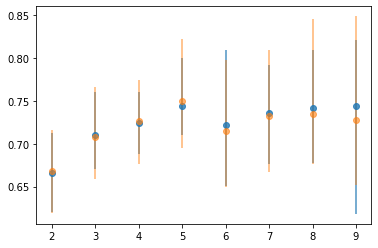

In [172]:
from matplotlib import pyplot
#Grafico metrica Accuracy con variacion del K de KFold
folds10 = range(2,10)
pyplot.errorbar(folds10, accuracyKFold10, yerr=[minaccuracyKFold10, maxaccuracyKFold10], fmt='o', alpha = 0.8)
pyplot.errorbar(folds10, FOneKFold10, yerr=[minFOneKFold10, maxFOneKFold10], fmt='o', alpha = 0.6)


#### Con K = 50

In [150]:
%%time
accuracyKFold50, minaccuracyKFold50, maxaccuracyKFold50, FOneKFold50, minFOneKFold50, maxFOneKFold50 = estudio_K_de_KFold(50, X_train, y_train)

CPU times: user 11.9 s, sys: 1.37 ms, total: 11.9 s
Wall time: 11.9 s


<ErrorbarContainer object of 3 artists>

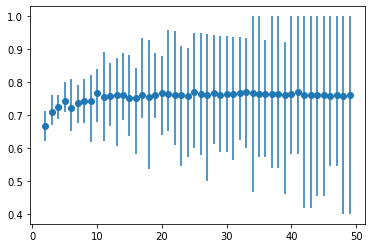

In [175]:
#Grafico metrica Accuracy con variacion del K de KFold
folds50 = range(2,50)
pyplot.errorbar(folds50, accuracyKFold50, yerr=[minaccuracyKFold50, maxaccuracyKFold50], fmt='o')
# pyplot.plot(folds, [ideal for _ in range(len(folds))], color='r')

<ErrorbarContainer object of 3 artists>

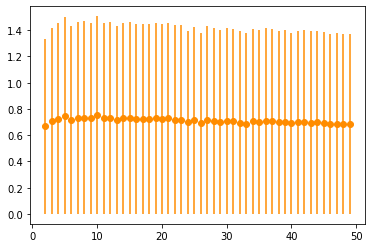

In [178]:
#Grafico metrica F1 con variacion del K de KFold
folds50 = range(2,50)
pyplot.errorbar(folds50, FOneKFold50, yerr=[FOneKFold50, FOneKFold50], fmt='o', color= 'darkorange')

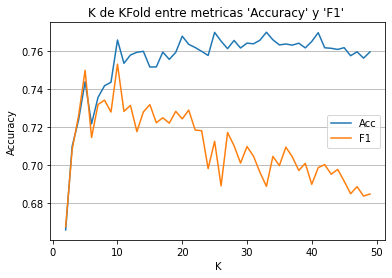

In [164]:
plt.title("K de KFold entre metricas 'Accuracy' y 'F1' ")
plt.plot(folds50, accuracyKFold50, label='Acc')
plt.plot(folds50, FOneKFold50, label='F1')
plt.legend(loc='center right')
plt.grid(axis='y')
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.show()

#### Con K = 100

In [187]:
%%time
accuracyKFold100, minaccuracyKFold100, maxaccuracyKFold100, FOneKFold100, minFOneKFold100, maxFOneKFold100 = estudio_K_de_KFold(100, X_train, y_train)

CPU times: user 31.6 s, sys: 43.1 ms, total: 31.7 s
Wall time: 31.9 s


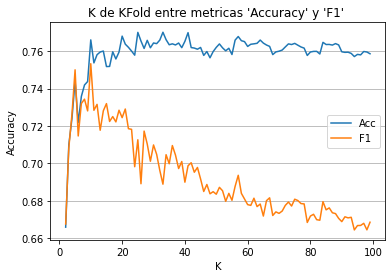

In [190]:
folds100 = range(2,100)

plt.title("K de KFold entre metricas 'Accuracy' y 'F1' ")
plt.plot(folds500, accuracyKFold500, label='Acc')
plt.plot(folds500, FOneKFold500, label='F1')
plt.legend(loc='center right')
plt.grid(axis='y')
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.show()

(0.2, 1.0)

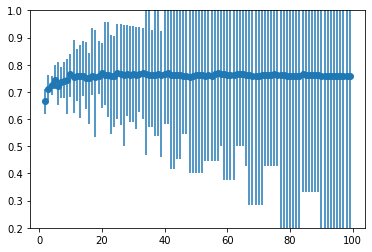

In [195]:
#Grafico metrica Accuracy con variacion del K = 500 de KFold
pyplot.errorbar(folds100, accuracyKFold100, yerr=[minaccuracyKFold100, maxaccuracyKFold100], fmt='o')
plt.ylim((0.2,1))

(0.2, 1.0)

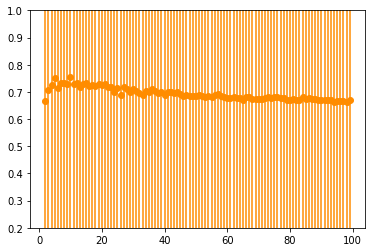

In [194]:
#Grafico metrica F1 con variacion del K = 500 de KFold
pyplot.errorbar(folds100, FOneKFold100, yerr=[FOneKFold100, FOneKFold100], fmt='o', color= 'darkorange')
plt.ylim((0.2,1))